In [ ]:
!pip install wandb

     |████████████████████████████████| 2.1MB 6.5MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 163kB 19.0MB/s 
     |████████████████████████████████| 133kB 12.4MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=4c8c554619430d92a03aea356e0fc1709bae84685033f74a97cdb5fb39c839f7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=71cd7b6e9201f39a43cad3a2db908c1dd1d8c64b85da0d5f1bfa2c0d9f91a02a
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


# Library

In [ ]:
from wandb.lightgbm import wandb_callback

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random

# Data Load & Preprocessing
- 훈련에 필요없는 index 컬럼 삭제.
- missing value를 모두 NAN 문자열로 대체
- dtype object 인 컬럼들을 onehot encoding

In [ ]:
train = pd.read_csv('train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('sample_submission.csv')

In [ ]:
'''train.drop(columns = 'child_num', inplace=True)
test.drop(columns = 'child_num', inplace=True)'''

"train.drop(columns = 'child_num', inplace=True)\ntest.drop(columns = 'child_num', inplace=True)"

In [ ]:
train.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64

In [ ]:
train = pd.read_csv('train.csv')

## 음수 -> 양수로 변환

In [ ]:
train['DAYS_BIRTH'] = -1 * train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -1 * train['DAYS_EMPLOYED']

test['DAYS_BIRTH'] = -1 * test['DAYS_BIRTH']
test['DAYS_EMPLOYED'] = -1 * test['DAYS_EMPLOYED']

## log 변환 

In [ ]:
candidate = ['income_total', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED']
for cand in candidate :
    train[cand] = np.log1p(train[cand])
    test[cand] = np.log1p(test[cand])

In [ ]:
train

In [ ]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED    4438
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type          0
family_size         0
begin_month         0
credit              0
dtype: int64

## 이상치 제거

In [ ]:
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train

candidate = ['income_total', 'DAYS_EMPLOYED', 'family_size']
for cand in candidate:  
    train = remove_outlier(train,cand)

train.reset_index(drop = True,inplace = True)
len(train)

outlier의 수 :  427
outlier의 수 :  0
outlier의 수 :  59


25971

In [ ]:

object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [ ]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

ValueError: ignored

In [ ]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

# Training
- 데이터 분리는 StratifiedKFold 를 사용하여 y값 분포를 비슷하게 분리시킴. -> 5-fold
- lightgbm의 default parameter로 훈련.
- 30번 이상 개선 없을 경우 중단.
- 각 5개의 fold를 훈련하여 저장

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
      
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
clf = XGBClassifier(n_estimators=1000)
my_submission = run_kfold(clf)

KeyboardInterrupt: ignored

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
random.seed(42)
lgb_models={}
sum_log = 0 
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')



====================================1============================================


ValueError: ignored

In [ ]:
(0.728147 +0.749101 + 0.749101 + 0.735449 + 0.734606) / 5

0.7392808

# Test inference
- 각 fold를 훈련시킨 lightgbm model로 predict.
- 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함.
- 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
- predict는 class 출력을 해주고 predict_proba는 class별 probability를 출력해줌.
- predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블.

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [ ]:
submit.to_csv('minus + children 제거.csv', index=False) 

In [ ]:
submit.head(20)

,index,0,1,2
0,26457,0.051405,0.107581,0.841014
1,26458,0.206987,0.152601,0.640412
2,26459,0.044073,0.116406,0.839521
3,26460,0.107357,0.117352,0.775291
4,26461,0.091080,0.183407,0.725514
5,26462,0.068352,0.142968,0.788680
6,26463,0.460201,0.539587,0.000212
7,26464,0.100599,0.136109,0.763291
8,26465,0.063873,0.160923,0.775204
9,26466,0.062235,0.297381,0.640384


In [ ]:
import matplotlib.pyplot as plt

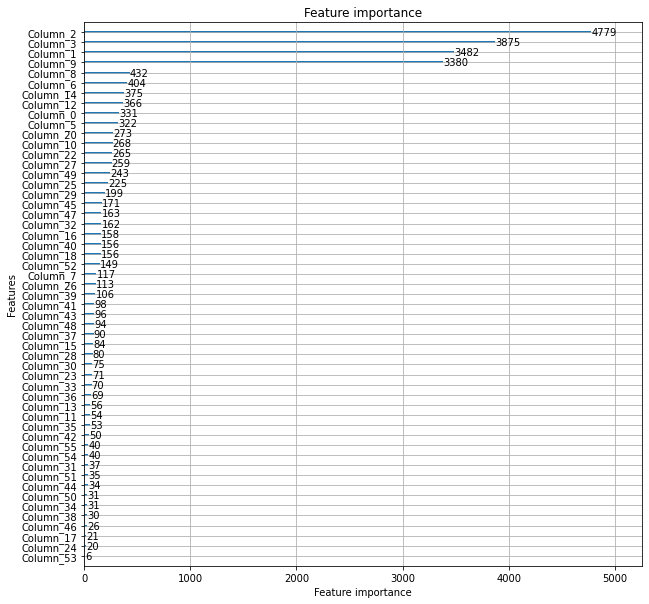

In [ ]:
from lightgbm import plot_importance
fig , ax = plt.subplots(figsize = (10,10))
plot_importance(lgb_models[0],ax = ax)

In [ ]:
train.columns

Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit', 'gender_F', 'gender_M', 'car_N', 'car_Y',
       'reality_N', 'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp